In [1]:
%pylab inline
import gc
import galsim
import numpy as np
import fpfsBase
import astropy.io.fits as pyfits

import fpfsBase

pltDir='plot/selBias/'
def measure(galImgAll,C):
    imgList=[galImgAll[i//nx*ngrid+beg:i//nx*ngrid+end,i%nx*ngrid+beg:i%nx*ngrid+end] for i in range(ngal)]
    a=fpTask.measure(imgList)
    b=fpfsBase.fpfsM2E(a,C)
    del imgList,a
    gc.collect()
    return b

def main(elli0,slow=0.,shigh=1.1,correct=True):
    dss=0.005
    elli=elli0.copy()
    mask=(elli['fpfs_s0']>slow)&(elli['fpfs_s0']<shigh)
    elli=elli[mask]
    mask2=(elli0['fpfs_s0']>slow-dss)&(elli0['fpfs_s0']<=slow+dss)
    RS2=-np.sqrt(2.)*np.sum((1-elli0[mask2]['fpfs_s0'])*elli0[mask2]['fpfs_e1']**2./2./dss)
    mask3=(elli0['fpfs_s0']>shigh-dss)&(elli0['fpfs_s0']<=shigh+dss)
    RS3=np.sqrt(2.)*np.sum((1-elli0[mask3]['fpfs_s0'])*elli0[mask3]['fpfs_e1']**2./2./dss)
    if correct:
        RS=RS2+RS3
    else:
        RS=0.
    g1=np.sum(elli['fpfs_e1'])/(np.sum(elli['fpfs_RE'])+RS)
    del mask,elli,mask2,RS
    gc.collect()
    return g1

def main2(elli0,slow=0.,shigh=1.1,correct=True):
    dss=0.005
    elli=elli0.copy()
    mask=(elli['fpfs_s0']>slow)&(elli['fpfs_s0']<shigh)
    elli=elli[mask]
    mask2=(elli0['fpfs_s0']>slow-dss)&(elli0['fpfs_s0']<=slow+dss)
    RS2=-np.sum(elli0[mask2]['fpfs_RS']/2./dss)
    mask3=(elli0['fpfs_s0']>shigh-dss)&(elli0['fpfs_s0']<=shigh+dss)
    RS3=np.sum(elli0[mask3]['fpfs_RS']/2./dss)
    if correct:
        RS=RS2+RS3
    else:
        RS=0.
    g1=np.sum(elli['fpfs_e1'])/(np.sum(elli['fpfs_RE'])+RS)
    del mask,elli,mask2,RS
    gc.collect()
    return g1

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd wrkDir/FPFS2/sim

/lustre/work/xiangchong.li/work/FPFS2/sim


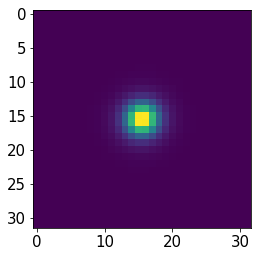

In [3]:
ngrid=64
nx=100;ny=100
ngal=nx*ny
scale=0.168
beta=0.75
psfFWHM=0.60
rcut=16
beg=ngrid//2-rcut
end=beg+2*rcut
# Initialize the fpfsTask
psfInt  =   galsim.Moffat(beta=3.5,fwhm=psfFWHM,trunc=psfFWHM*4.)
psfInt  =   psfInt.shear(e1=0.02,e2=-0.02)
psfImg  =   psfInt.drawImage(nx=64,ny=64,scale=scale)
psfData =   psfImg.array[beg:end,beg:end]
plt.imshow(psfData)
fpTask=fpfsBase.fpfsTask(psfData,beta=beta)

0.012181993432561338


/lustre/work/xiangchong.li/ana/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


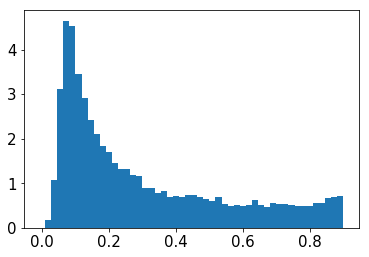

In [5]:
C=2000.
import numpy.lib.recfunctions as rfn

elli1=[]
elli2=[]
for ifield in range(1):
    # read galaxy image
    galImgAll1=pyfits.getdata('galaxy_basic_psf%d/image-%d-g1-2222.fits' %(psfFWHM*100,ifield))
    galImgAll2=pyfits.getdata('galaxy_basic_psf%d/image-%d-g1-0000.fits' %(psfFWHM*100,ifield))
    elli1U=measure(galImgAll1,C)
    elli2U=measure(galImgAll2,C)
    elli1.append(elli1U)
    elli2.append(elli2U)
    del elli1U,elli2U,galImgAll1,galImgAll2
    gc.collect()
elli1=rfn.stack_arrays(elli1,usemask=False)
elli2=rfn.stack_arrays(elli2,usemask=False)
plt.hist(elli1['fpfs_s0'],bins=50,range=(-0.01,0.90),density=True)
print(elli1['fpfs_s0'].min())

0.17727235688724405 0.18024962403577383


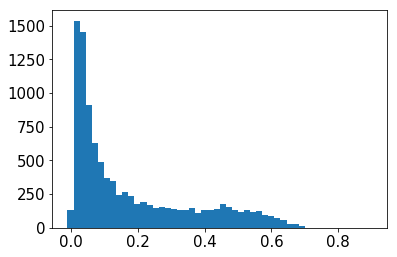

In [7]:
_=plt.hist(elli1['fpfs_RE'],bins=50,range=(-0.01,0.90))
print(np.average(elli1['fpfs_RE']),np.std(elli1['fpfs_RE']))

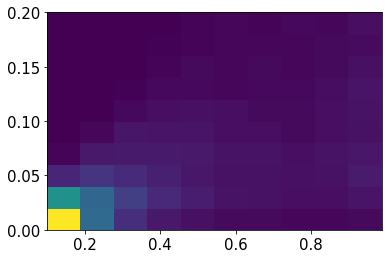

In [34]:
_=plt.hist2d(elli1['fpfs_s0'],np.sqrt(elli1['fpfs_eSquare']),bins=10,range=((0.1,0.99),(0.,0.2)))

[-1.01490215e-03 -1.22821239e-03 -9.57799409e-04 -9.17595401e-05
 -1.83248139e-03 -2.21402570e-03 -9.25221627e-05 -2.10133111e-03]


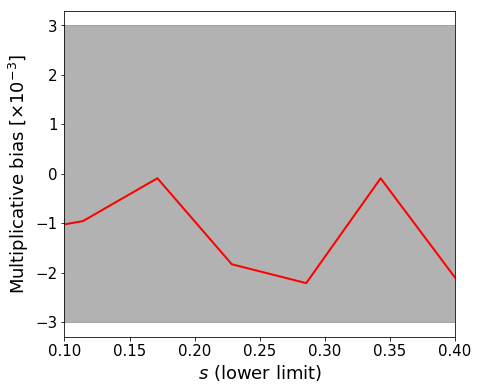

In [11]:
gest=[]
slowList=np.linspace(0.,0.4,8)
corr=True

for slow in slowList:
    g1p=main2(elli1,slow,1.0,corr)
    g1m=main2(elli2,slow,1.0,corr)
    gest.append(g1m-g1p)
    gc.collect
gest=np.array(gest)/0.04-1
print(gest)

plt.close()
fig=plt.figure(figsize=(7,6))
ax=fig.add_subplot(1,1,1)
ax.plot(slowList,gest*1e3,c='red',markersize=10)
ax.set_xlim(0.1,0.4)

ax.set_xlabel(r'$s$ (lower limit)')
ax.set_ylabel(r'Multiplicative bias [$\times 10^{-3}$]')
ax.fill_between(slowList,-3*np.ones(len(slowList)),3*np.ones(len(slowList)),color='gray',alpha=0.6)
fig.savefig(os.path.join(pltDir,'selBias_wonoise_low.png'))
fig.savefig(os.path.join(pltDir,'selBias_wonoise_low.pdf'))

[-0.00046277  0.00194087 -0.00097231 -0.00122239 -0.00129239]


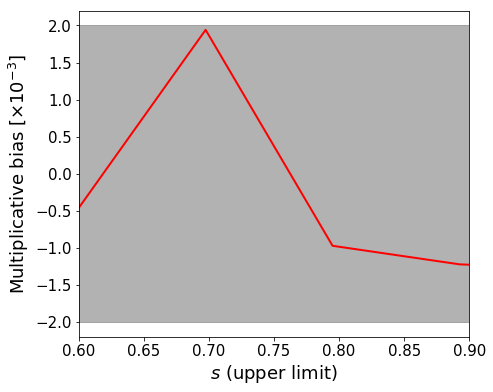

In [35]:
gest=[]
shighList=np.linspace(0.6,0.99,5)
for shigh in shighList:
    g1p=main2(elli1,0.,shigh,corr)
    g1m=main2(elli2,0.,shigh,corr)
    gest.append(g1m-g1p)
    gc.collect
gest=np.array(gest)/0.04-1
print(gest)
    
plt.close()
fig=plt.figure(figsize=(7,6))
ax=fig.add_subplot(1,1,1)
ax.plot(shighList,gest*1e3,c='red',markersize=10)
ax.set_xlim(0.6,0.9)

ax.set_xlabel(r'$s$ (upper limit)')
ax.set_ylabel(r'Multiplicative bias [$\times 10^{-3}$]')
ax.fill_between(shighList,-2*np.ones(len(slowList)),2*np.ones(len(slowList)),color='gray',alpha=0.6)
fig.savefig(os.path.join(pltDir,'selBias_wonoise_high.png'))
fig.savefig(os.path.join(pltDir,'selBias_wonoise_high.pdf'))